### Goal: systematic, unbiased search for mid-long term causal effects of treatments
We want to look across all treatments, for causal associations of treatment with cancer onset (or other high-impact non-transient outcomes). Thus, we would like compare the rate of disease among the treated to an estimated rate if those same people were never exposed. While it is easy to measure observed outcome after treatment, estimating the counterfactual outcome requires defining a matching population using unexposed time in our data.

### Distinctions from previous literature
While I want to build on the large body of work that's been done in this area, there are some significant differences with previous work.

1) Differences in the question being asked:
- **1.1) Long term, non-transient effects**. Since an outcome like cancer is influential, reverse-causality will have a bigger impact if we include any time after outcome. This is a problem for self-matched methods like the self-controlled case series.  Also, we do not know the amount of time after exposure that is relevant for disease development. Ideally our method would be flexible to this.
- **1.2) Systematic search**.  We want to scan systematically across all drugs, without background knowledge.  Most studies search one drug at a time, defining the comparison population using domain knowledge. For example: 
    - Among post-menopausal women, do those who take combination hormones have higher rates of breast cancer than those who take no hormones?  
    - How do new users of coxibs compare to new users other nSAIDS in development of a certain outcome?
    
2) Differences in the data available:
- **2.1) High-dimensional covariates (patient history)**. Matching methods, including coarsened exact matching, generally come from domains with at most a few dozen covariates and manual curation of covariates. They can do this because they are testing only one causal effect (point **1.2** above). Here we have ~thousands of covariates, though many of them are irrelevant to a given population definition.
- **2.2) Temporal data**. If someone gets pneumonia, they are more likely to take certain drugs during the period after that diagnosis than they would be at other points in their history. We need to choose time periods of interest for each person. For treated people, this is obviously time after treatment, but for untreated people it is not obvious.
- **2.3) Missing/unobserved data**. For example, the Nurse Health Study samples people every 2 years, and if people drop out they are censored. In our data, people are observed with varying intensity, and people with more data have a different probability of treatment, and I'd guess they have a different probability of disease (data is not "missing completely at random"). A person diagnosed with pneumonia first had to be observed.
    
### Matching using untreated patients
Self-matched methods seemed nice in theory because a patient should have a similar probability of developing disease at any given time point. Then, we could assess impact of drug by comparing exposed versus unexposed time in the same patient. But, because of point **1.1** above, I've basically abandoned self-matched methods. 

That leaves us with unexposed time observed in untreated patients, without any history of the disease, as our only comparison point. We want to match the treated population to the untreated population.  There seem to be two ways:
- **For each treated person, match an untreated patient**. But we can't exactly do this because we have high-dimensional data (**2.1**). Although you can match on the propensity score which is univariate, [this paper from Gary King](https://gking.harvard.edu/files/gking/files/psnot.pdf) explains why this is a bad idea, especially in high dimensional data.  For example, below, the 2 axes are covariates that we must adjust for that differ between treated (red) and control (blue). Then, the propensity score increases from (0,0) (bottom left) to (6,6) (top right), such as $P(Treated) = (X1 + X2)/12$. Matching on propensity score (the right plot) can pair up points that fall far apart on the original covariate space, versus if you matched each point to its nearest neighbor (left plot).

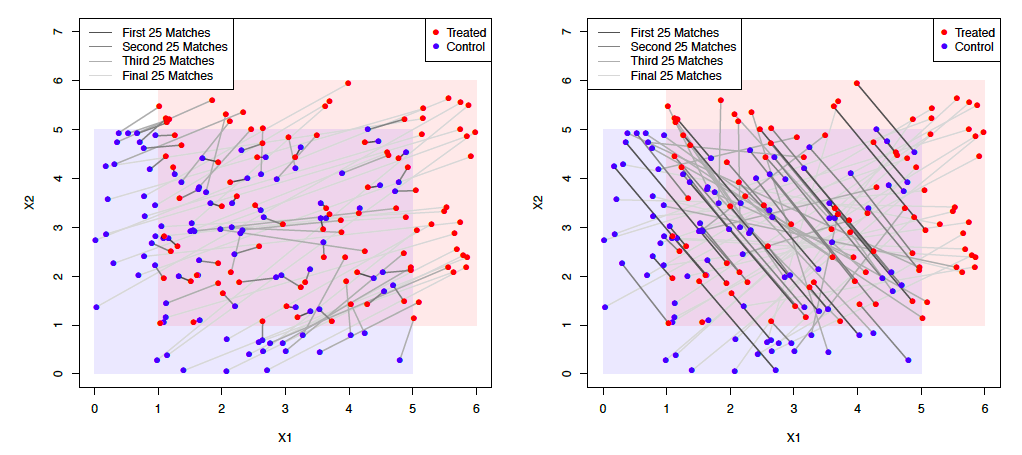

In [2]:
from IPython.display import Image 
Image(filename='png/kingFig2.png')

- **Create matched pseudo-populations**: this is the idea of inverse propensity weighting. The propensity for treatment $D$ given patient history $X$ is $P(D | X)$. The problem above is not so much with the misspecification of the propensity score as with using it for matching. Instead, we can create the pseudo-population that represents the distribution of outcomes if everyone got each exposure (figure below), and use it to estimate the potential outcomes $E[Y^T]$ for $T \in {Treat, Unexposed}$:
$$ E_{ps}[Y^T] = \sum_{i \in Y_i=T} {1 \over {P(D=T | X_i)} } \cdot Y_i $$

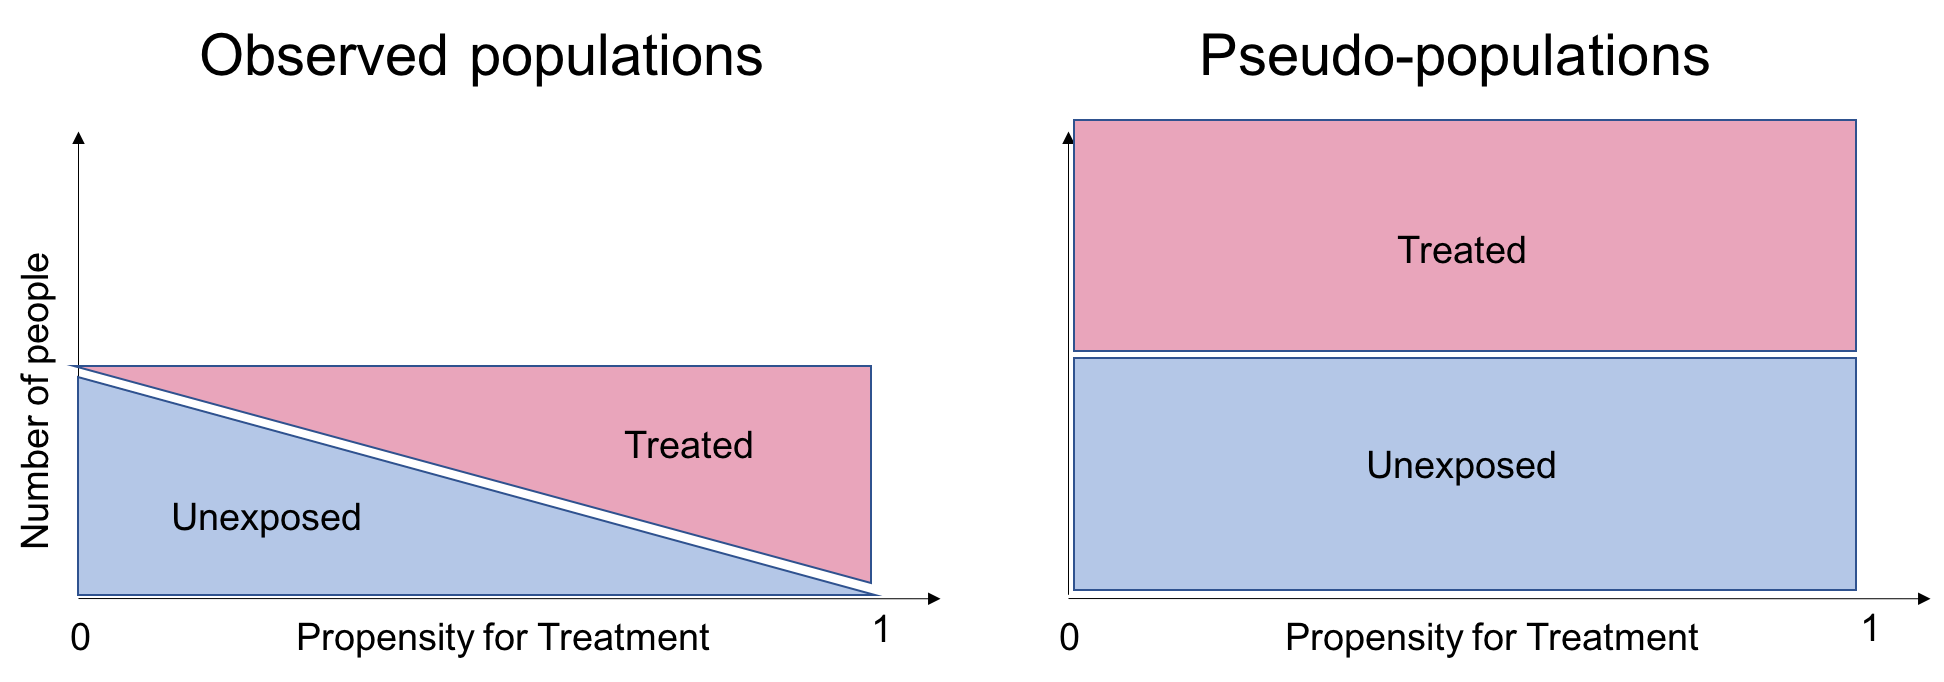

In [11]:
Image(filename='png/pseudopops.png')

### Temporal matching, and matching for observation
Assuming we take the pseudo-population approach above, and assuming we can estimate the propensity score for treatment given a patient history, at a given time point, there are still remaining questions. 

First, how should we match temporally?  Assuming we want to use all eligible treated people (with no history of the outcome, and with washout period), then the period of outcome evaluation is fixed for each treated person like Dave below left.  But for a person with no history of drug *d* like Joe, right, there are multiple possible windows $w$ for evaluating the outcome $Y_{Joe,w}$, and for evaluating the propensity for drug $P(D | X_w)$

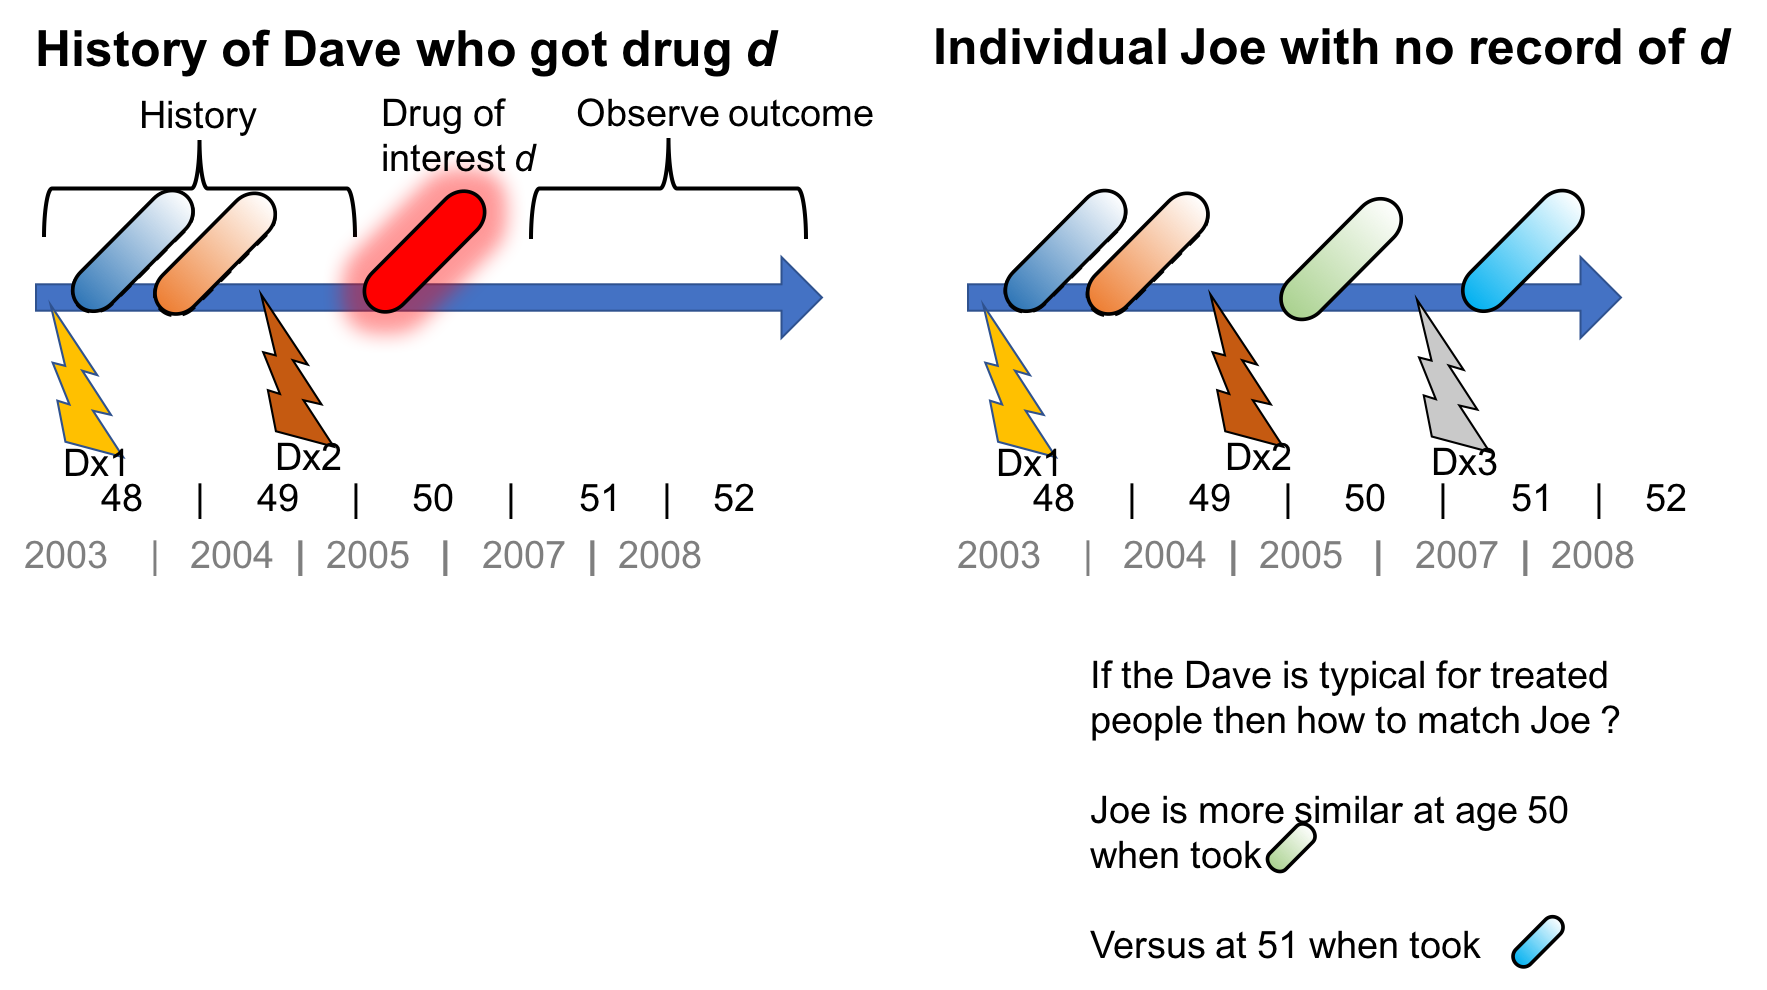

In [10]:
Image(filename='png/temporal_match.png')

If we define possible windows times starting with a new prescriptions of a drug, some choices of how to use patients with no use of *d* are:
- Pick one window per person totally at random (pick one of $N$ new-user prescriptions with probability $ 1/N $), which seems unpromising since the Treated windows were not picked at random. If the person has cancer before this time window, don't use the person.
- Pick one window per person at random so overall sample of untreated reflects full distribution of untreated time windows.  Again remove people with cancer before this time window.
- Don't pick any comparison window, but evaluate over all observations per patient using marginal structural models or g-estimation [methods of Hernan/Robins](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2013/01/RobinsHernan_Chapter_23.pdf), which I'm still trying to understand. Hernan & Robins used this to [estimate](https://insights.ovid.com/pubmed?pmid=18854702) heart disease risk in women taking hormone therapy

Another question, even if we have a great way of picking the observation windows, is how to deal with variation in the amount of observations per person.  If someone is taking a rare drug, then maybe that person is more sick and has more of every disease than someone who only has one Rx and it is for amoxicillin. It will also be necessary to adjust for this, which Hernan & Robins [suggest](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) doing using probability of censoring, Missing At Random (MAR) techniques, which I'm also working out.

